# (L0,L1) smoothness and Frank-Wolfe on log regression. Version 3

Версия 2 пропущена, т.к. в ней почти ничего не было нового.

### Целевая функция

Будем оптимизировать функцию лог-регрессии
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \text{log}(1 + \text{exp}(-y_i (Ax)_i))
$$
, где $x \in \mathbb{R}^d$, $L= \text{max}_i \| A_i \|^2$, $L_0 = 0$, $L_1 = \text{max}_i \| A_i \|$ $(\| A_i \| >> 1)$

### Данные 
1) Попробуем генерацию на высоких размерностях. А так же на задачах, где количество фич намного меньше, чем размерность.
2) Низкообусловленные данные:
    1) высокая корреляция между столбцами
    2) последние колонки отшкалированы
    3) Случайно меняем знак у некоторых классов
3) Когда решение низкоразреженное. Попробуем для начала генерировать на $l_{\infty}$-шаре и на симплексе. Решения будут низкоразреженные, что позволит увидеть лучше, кто точно генерирует решение, а кто нет
4) Попробуем менять зашумленность классов: будем менять `margin`, `class_bias`, может быть еще `noise`


См. все в функции `hard_FW_log_reg_jax`

### Алгоритмы
В экспериментах сравниваются следующие методы:
- Алгоритм Франк-Вульфа с шагом основанным на L0,L1 гладкости (FW-L0_L1)
- Алгоритм Франк-Вульфа с шагом основанным на L0,L1 гладкости с логарифмическим шагом (FW-L0_L1_log)
- Алгоритм Франк-Вульфа классический (FW-stand) с shortest step

### Цель эксперимента

На всех предыдущих экспериментаз алгоритмы вели себя почти что одинаково. Я решил, что это потому что задачи слишком легкие, т.к. я заметил, что скорость сходимости там у них очень высокая: они быстро сходятся к решению и затем болтаются около нуля и не видно, кто из них лучше, а кто хуже.

Тут мы все же попытаемся выявить "Какой из алгоритмов будет быстрее всех сходится? При каких условиях? Почему?"

Новые "сложные" данные генерируются в функции `hard_FW_log_reg_jax`, предыдущая версия сохранена в `L0L1_FW_log_reg`, там уже есть половина от `hard_FW_log_reg_jax`, я там начал ее реализовывать, но не закончил.

Я уже не так оптимистичен по отношению к новым алгоритмам, так как мы меняем только длину шага, а сам алгоритм у нас особо никак не меняется. Но я все же думаю, что 
$$
\alpha_k = \frac{- (\nabla f(x_k)^\top d_k)}{(L_0^{(k)} + L_1^{(k)} \|\nabla f(x_k)\|) \|d_k\|^2 e}
$$
будет лучше себя вести на задачах с большими размерностями. Пчму? Птмчто в среднем константа $L_0^{(k)} + L_1^{(k)} \|\nabla f(x_k)\|$ у нее будет ниже, чем классическая$L$ и классический алгоритм будет падать, когда $L$ будет слишком высоким.

In [2]:
import sys
import os

# Get the parent directory of the notebook (2 levels up)
notebook_dir = os.path.abspath(os.path.join(os.getcwd(), "../../"))
if notebook_dir not in sys.path:
    sys.path.append(notebook_dir)

In [3]:
import numpy as np
import jax
import matplotlib.pyplot as plt

import accbpg

In [4]:
plt.rcParams.update({
    'font.size': 14,        # общий размер шрифта
    'font.family': 'serif',
    'axes.titlesize': 16,   # размер заголовков графиков
    'axes.labelsize': 15,   # размер подписей осей
    'legend.fontsize': 13,  # размер легенды
    'xtick.labelsize': 13,  # подписи на осях X
    'ytick.labelsize': 13   # подписи на осях Y
})

## Низкообусловленная задача

### Низкообусловленная задача. $L_2$-шар. Меняем число векторов.

Running for n_samples=2000, n_features=200

FW L0,L1 smooth logarithmic algorithm
     k      F(x)         L         L0         L1     log step count       time
     0    6.931e-01    2.609e+01    4.545e-13    1.850e+01        1         0.2
   500    5.422e-01    7.311e+00    1.065e-11    4.333e+02      501         2.6
  1000    5.334e-01    1.074e+01    2.343e-11    9.534e+02     1001         4.9
  1500    5.293e-01    1.120e+01    2.343e-11    9.534e+02     1501         7.2
  2000    5.265e-01    7.507e+00    2.343e-11    9.534e+02     2001         9.7
  2500    5.246e-01    7.477e+00    2.343e-11    9.534e+02     2501        12.2
  3000    5.226e-01    2.557e+00    1.065e-11    4.333e+02     3001        14.6
  3500    5.202e-01    2.164e+00    1.065e-11    4.333e+02     3501        17.2
  4000    5.185e-01    4.398e+00    2.343e-11    9.534e+02     4001        19.5
  4500    5.175e-01    4.141e+00    2.343e-11    9.534e+02     4501        21.9

FW L0,L1 smooth algorithm with fixed L

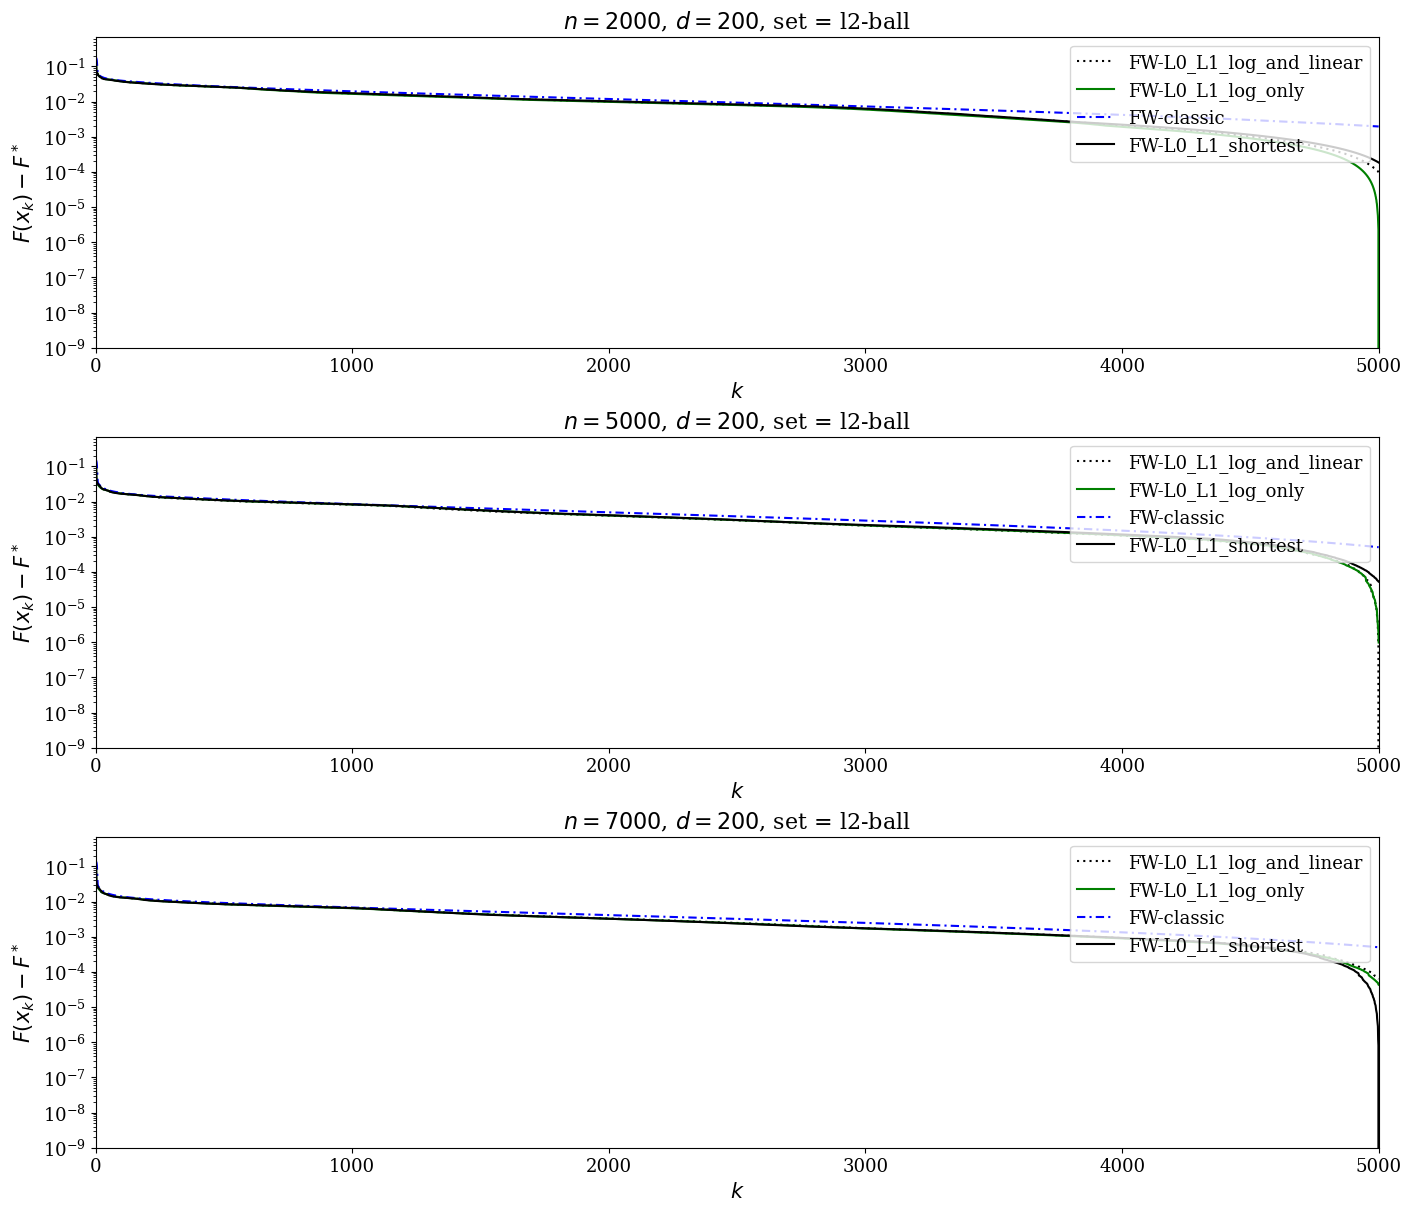

In [13]:
fig, axes = plt.subplots(
    3, 1,
    figsize=(14, 12),
    sharex=False,
    sharey=False,
    constrained_layout=True
)


eps = 1e-8
max_iters = 5000
verbskip = max_iters / 10
ls_ratio = 2.2

key = jax.random.key(63)

l1_max_factor = 5
ball_constrnt_radius = 25


labels = [r"FW-L0_L1_log_and_linear", r"FW-L0_L1_log_only", r"FW-classic", r"FW-L0_L1_shortest"]

configs = [
    (2000, 200),
    (5000, 200),
    (7000, 200),
]

for i, (n_samples, n_features) in enumerate(configs):
    print(f"Running for n_samples={n_samples}, n_features={n_features}")
    f, h, L, L0, L1, x0, X_data, y_true = accbpg.hard_FW_log_reg_jax(key, 
                                                     n_samples, n_features, 
                                                     radius=ball_constrnt_radius, 
                                                     domain="l2",
                                                     rho=0.99,
                                                     col_scale=1.0,
                                                     flip_y=0.2,
                                                     noise=0.1)
    lmo = accbpg.lmo_l2_ball(ball_constrnt_radius)
    lmo_name = "l2-ball"

    _, F_l0l1_log, _, _, _ = accbpg.FW_l0l1_log_and_linear_step(
        f, h, L0, L1, x0, max_iters, lmo, ls_ratio=ls_ratio, 
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    _, F_l0_l1_step_fixed_l1, _, _, _ = accbpg.FW_l0l1_log_only(
        f, h, L0, L1, x0, maxitrs=max_iters, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    _, F_standard, _, _ = accbpg.FW_alg_div_step(
        f, h, L, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    _, F_l0_l1_step, _, _ = accbpg.FW_alg_L0_L1_shortest_step(
        f, h, L0, L1, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    y_min = min(np.min(F_l0l1_log), np.min(F_standard), np.min(F_l0_l1_step), np.min(F_l0_l1_step_fixed_l1))
    y_max = max(np.max(F_l0l1_log), np.max(F_standard), np.max(F_l0_l1_step), np.max(F_l0_l1_step_fixed_l1))

    max_executed_iters = max(len(F_l0l1_log), len(F_standard), len(F_l0_l1_step), len(F_l0_l1_step_fixed_l1))

    ax = axes[i]
    accbpg.plot_comparisons(
        ax,
        [F_l0l1_log, F_l0_l1_step_fixed_l1, F_standard, F_l0_l1_step],
        labels,
        xlim=[0, max_executed_iters],
        ylim=[1e-9, y_max],  # Adjusted for log scale
        x_vals=[], plotdiff=True, yscale="log",
        xlabel=r"$k$",
        ylabel=r"$F(x_k) - F^*$",
        legendloc="upper right"
    )

    ax.set_title(f"$n = {n_samples}$, $d = {n_features}$, set = {lmo_name}")

# Optional: save the figure
# plt.savefig("FW_comparison_grid.pdf", bbox_inches='tight')
plt.show()

### Низкообусловленная задача. $L_2$-шар. Меняем размерность.

Running for n_samples=200, n_features=2000

FW L0,L1 smooth logarithmic algorithm
     k      F(x)         L         L0         L1     log step count       time
     0    6.931e-01    1.405e+02    4.545e-13    2.999e+01        1         0.2

FW L0,L1 smooth algorithm with fixed L1
     k      F(x)         L         L0         L1     log step count       time
     0    6.931e-01    1.405e+02    4.545e-13    2.999e+01        1         0.0

FW adaptive algorithm
     k      F(x)         Lk       time
     0   6.931e-01   1.979e+03     0.0

FW L0,L1 smooth algorithm
     k      F(x)         L           L0              L1     step-size     time
     0    6.931e-01    1.405e+02     4.545e-13       2.999e+01        9.813e-04        0.0
Running for n_samples=200, n_features=5000

FW L0,L1 smooth logarithmic algorithm
     k      F(x)         L         L0         L1     log step count       time
     0    6.931e-01    2.100e+02    4.545e-13    4.137e+01        1         0.2

FW L0,L1 smooth alg

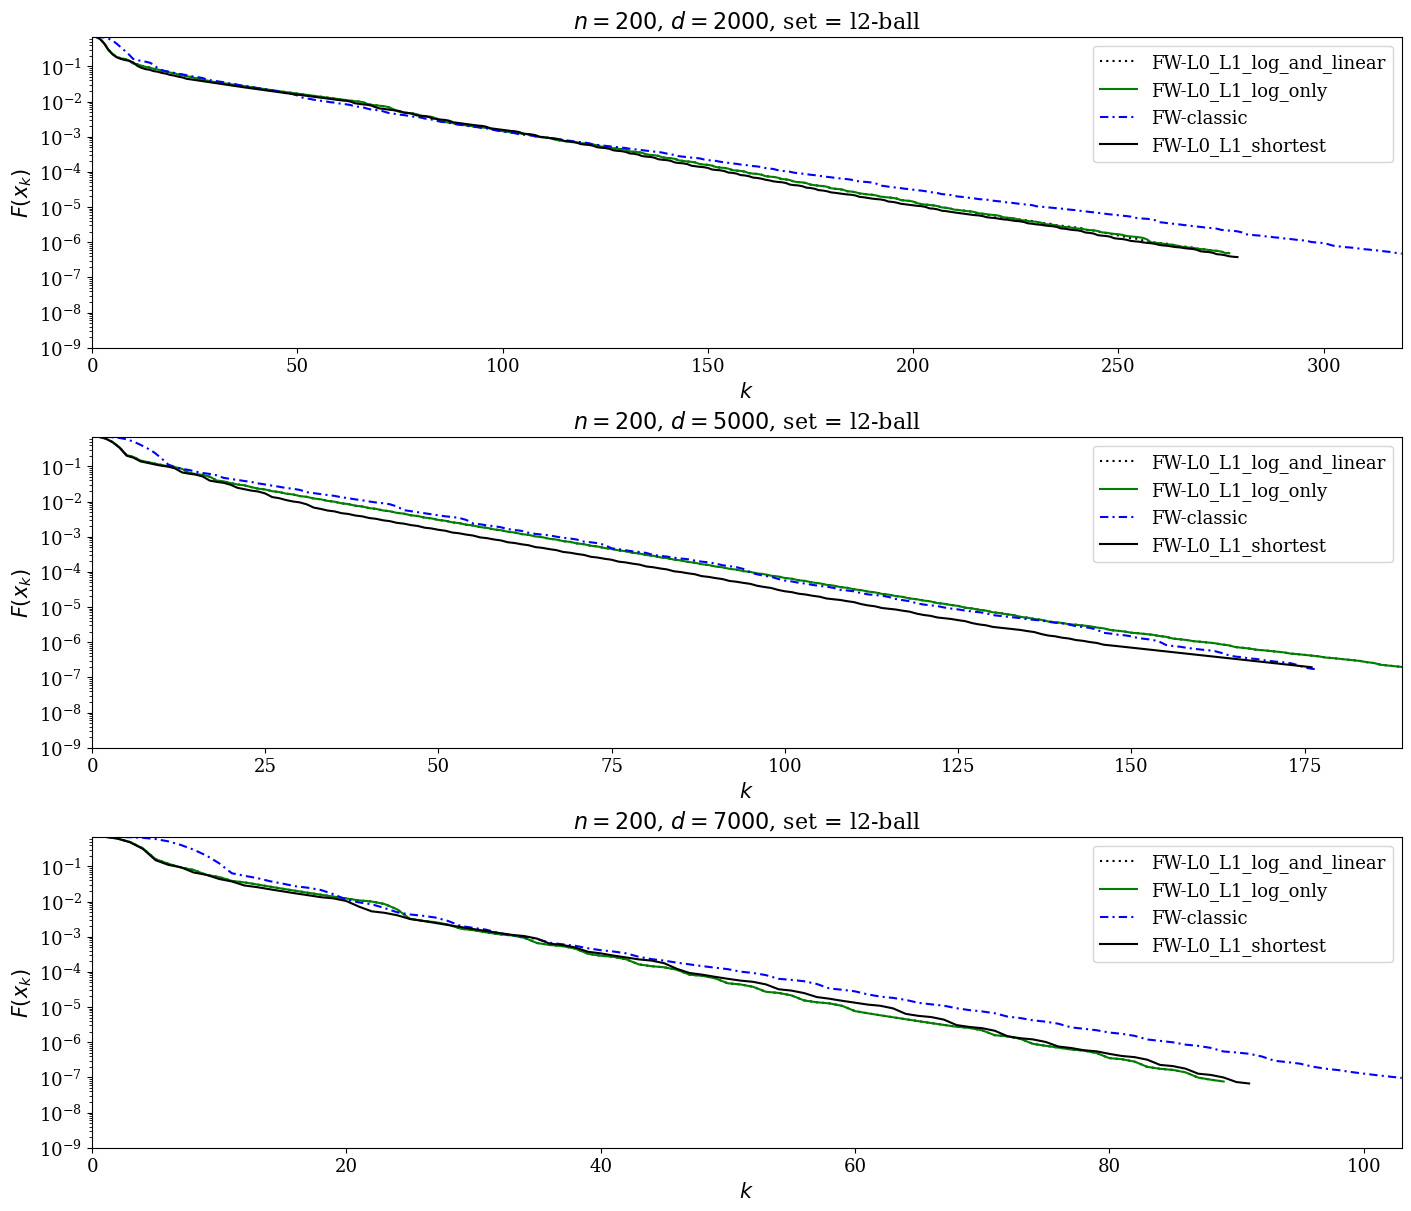

In [14]:
fig, axes = plt.subplots(
    3, 1,
    figsize=(14, 12),
    sharex=False,
    sharey=False,
    constrained_layout=True
)


eps = 1e-8
max_iters = 5000
verbskip = max_iters / 10
ls_ratio = 2.2

key = jax.random.key(33)

l1_max_factor = 5
ball_constrnt_radius = 25


labels = [r"FW-L0_L1_log_and_linear", r"FW-L0_L1_log_only", r"FW-classic", r"FW-L0_L1_shortest"]

configs = [
    (200, 2000),
    (200, 5000),
    (200, 7000),
]

for i, (n_samples, n_features) in enumerate(configs):
    print(f"Running for n_samples={n_samples}, n_features={n_features}")
    f, h, L, L0, L1, x0, X_data, y_true = accbpg.hard_FW_log_reg_jax(key, 
                                                     n_samples, n_features, 
                                                     radius=ball_constrnt_radius, 
                                                     domain="l2",
                                                     rho=0.99,
                                                     col_scale=1.0,
                                                     flip_y=0.0,
                                                     noise=0.1)
    lmo = accbpg.lmo_l2_ball(ball_constrnt_radius)
    lmo_name = "l2-ball"

    _, F_l0l1_log, _, _, _ = accbpg.FW_l0l1_log_and_linear_step(
        f, h, L0, L1, x0, max_iters, lmo, ls_ratio=ls_ratio, 
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    _, F_l0_l1_step_fixed_l1, _, _, _ = accbpg.FW_l0l1_log_only(
        f, h, L0, L1, x0, maxitrs=max_iters, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    _, F_standard, _, _ = accbpg.FW_alg_div_step(
        f, h, L, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    _, F_l0_l1_step, _, _ = accbpg.FW_alg_L0_L1_shortest_step(
        f, h, L0, L1, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    y_min = min(np.min(F_l0l1_log), np.min(F_standard), np.min(F_l0_l1_step), np.min(F_l0_l1_step_fixed_l1))
    y_max = max(np.max(F_l0l1_log), np.max(F_standard), np.max(F_l0_l1_step), np.max(F_l0_l1_step_fixed_l1))

    max_executed_iters = max(len(F_l0l1_log), len(F_standard), len(F_l0_l1_step), len(F_l0_l1_step_fixed_l1))

    ax = axes[i]
    accbpg.plot_comparisons(
        ax,
        [F_l0l1_log, F_l0_l1_step_fixed_l1, F_standard, F_l0_l1_step],
        labels,
        xlim=[0, max_executed_iters],
        ylim=[1e-9, y_max],  # Adjusted for log scale
        x_vals=[], plotdiff=False, yscale="log",
        xlabel=r"$k$",
        ylabel=r"$F(x_k)$",
        legendloc="upper right"
    )

    ax.set_title(f"$n = {n_samples}$, $d = {n_features}$, set = {lmo_name}")

# Optional: save the figure
# plt.savefig("FW_comparison_grid.pdf", bbox_inches='tight')
plt.show()

### Низкообусловленная задача. $L_{\infty}$-шар

Running for n_samples=2000, n_features=200

FW L0,L1 smooth logarithmic algorithm
     k      F(x)         L         L0         L1     log step count       time
     0    6.931e-01    6.477e+02    4.545e-13    8.862e+01        1         0.1
   200    5.629e-01    3.043e+02    1.065e-11    2.076e+03      201         1.1
   400    5.577e-01    2.748e+01    2.200e-12    4.289e+02      401         2.0
   600    5.546e-01    4.936e+01    4.840e-12    9.436e+02      601         2.9
   800    5.528e-01    1.025e+02    1.065e-11    2.076e+03      801         3.8
  1000    5.513e-01    1.713e+01    2.200e-12    4.289e+02     1001         4.7
  1200    5.500e-01    3.670e+01    4.840e-12    9.436e+02     1201         5.9
  1400    5.490e-01    1.911e+02    2.343e-11    4.567e+03     1401         6.9
  1600    5.481e-01    2.122e+02    2.343e-11    4.567e+03     1601         7.8
  1800    5.473e-01    6.648e+01    1.065e-11    2.076e+03     1801         8.7

FW L0,L1 smooth algorithm with fixed L

d:\projects\accbpg_and_fw\accbpg\plotfigs.py:48: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axis.set_ylim(ylim)


Running for n_samples=5000, n_features=200

FW L0,L1 smooth logarithmic algorithm
     k      F(x)         L         L0         L1     log step count       time
     0    6.931e-01    7.451e+02    4.545e-13    1.013e+02        1         0.2
   200    5.656e-01    1.140e+02    4.840e-12    1.079e+03      201         1.3
   400    5.618e-01    1.515e+02    1.065e-11    2.373e+03      401         2.5
   600    5.602e-01    1.167e+02    1.065e-11    2.373e+03      601         3.6
   800    5.592e-01    4.303e+01    4.840e-12    1.079e+03      801         4.7
  1000    5.581e-01    3.392e+01    4.840e-12    1.079e+03     1001         5.9
  1200    5.572e-01    1.920e+02    2.343e-11    5.220e+03     1201         7.0
  1400    5.565e-01    1.571e+02    2.343e-11    5.220e+03     1401         8.2
  1600    5.559e-01    1.584e+02    2.343e-11    5.220e+03     1601         9.4
  1800    5.555e-01    1.367e+02    2.343e-11    5.220e+03     1801        10.7

FW L0,L1 smooth algorithm with fixed L

d:\projects\accbpg_and_fw\accbpg\plotfigs.py:48: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axis.set_ylim(ylim)


Running for n_samples=7000, n_features=200

FW L0,L1 smooth logarithmic algorithm
     k      F(x)         L         L0         L1     log step count       time
     0    6.931e-01    7.414e+02    4.545e-13    9.941e+01        1         0.2
   200    5.666e-01    4.955e+01    2.200e-12    4.811e+02      201         1.6
   400    5.622e-01    1.535e+02    1.065e-11    2.329e+03      401         3.3
   600    5.600e-01    1.257e+02    1.065e-11    2.329e+03      601         4.6
   800    5.587e-01    8.347e+01    1.065e-11    2.329e+03      801         6.0
  1000    5.577e-01    8.031e+01    1.065e-11    2.329e+03     1001         7.6
  1200    5.570e-01    6.666e+01    1.065e-11    2.329e+03     1201         9.1
  1400    5.564e-01    2.080e+02    2.343e-11    5.123e+03     1401        10.6
  1600    5.559e-01    6.087e+01    1.065e-11    2.329e+03     1601        11.9
  1800    5.554e-01    1.471e+02    2.343e-11    5.123e+03     1801        13.3

FW L0,L1 smooth algorithm with fixed L

d:\projects\accbpg_and_fw\accbpg\plotfigs.py:48: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axis.set_ylim(ylim)


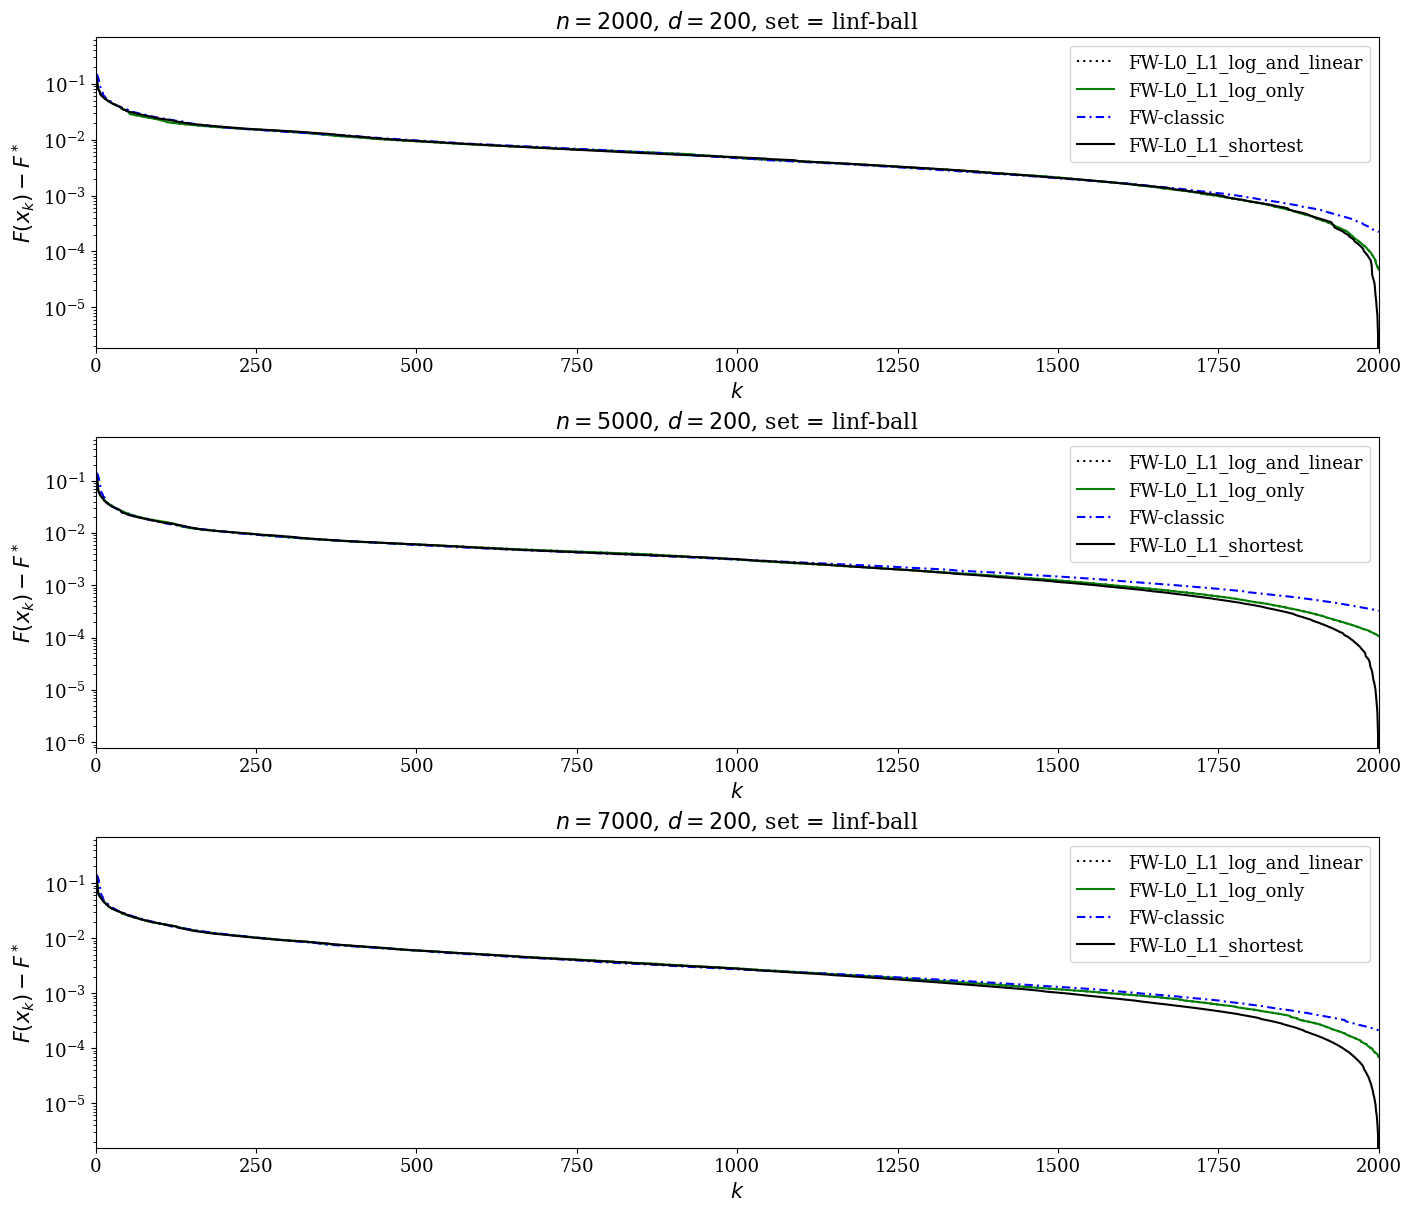

In [21]:
fig, axes = plt.subplots(
    3, 1,
    figsize=(14, 12),  # увеличенная ширина и особенно высота
    sharex=False,   # keep only shared x-axis
    sharey=False,  # allow separate y-limits
    constrained_layout=True
)


eps = 1e-8
max_iters = 2000
verbskip = max_iters / 10
ls_ratio = 2.2

key = jax.random.key(836)

l1_max_factor = 5
ball_constrnt_radius = 25


labels = [r"FW-L0_L1_log_and_linear", r"FW-L0_L1_log_only", r"FW-classic", r"FW-L0_L1_shortest"]

configs = [
    (2000, 200),
    (5000, 200),
    (7000, 200),
]

for i, (n_samples, n_features) in enumerate(configs):
    print(f"Running for n_samples={n_samples}, n_features={n_features}")
    f, h, L, L0, L1, x0, X_data, y_true = accbpg.hard_FW_log_reg_jax(key, 
                                                     n_samples, n_features, 
                                                     radius=ball_constrnt_radius, 
                                                     domain="linf",
                                                     rho=0.99,
                                                     col_scale=10.0,
                                                     flip_y=0.2,
                                                     noise=0.01)
    lmo = accbpg.lmo_linf_ball(ball_constrnt_radius)
    lmo_name = "linf-ball"

    _, F_l0l1_log, _, _, _ = accbpg.FW_l0l1_log_and_linear_step(
        f, h, L0, L1, x0, max_iters, lmo, ls_ratio=ls_ratio, 
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    _, F_l0_l1_step_fixed_l1, _, _, _ = accbpg.FW_l0l1_log_only(
        f, h, L0, L1, x0, maxitrs=max_iters, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    _, F_standard, _, _ = accbpg.FW_alg_div_step(
        f, h, L, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    _, F_l0_l1_step, _, _ = accbpg.FW_alg_L0_L1_shortest_step(
        f, h, L0, L1, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )


    y_min = min(np.min(F_l0l1_log), np.min(F_standard), np.min(F_l0_l1_step), np.min(F_l0_l1_step_fixed_l1))
    y_max = max(np.max(F_l0l1_log), np.max(F_standard), np.max(F_l0_l1_step), np.max(F_l0_l1_step_fixed_l1))

    max_executed_iters = max(len(F_l0l1_log), len(F_standard), len(F_l0_l1_step), len(F_l0_l1_step_fixed_l1))

    ax = axes[i]
    accbpg.plot_comparisons(
        ax,
        [F_l0l1_log, F_l0_l1_step_fixed_l1, F_standard, F_l0_l1_step],
        labels,
        xlim=[0, max_executed_iters], 
        ylim=[0, y_max], 
        plotdiff=True, 
        yscale="log",
        xlabel=r"$k$",
        ylabel=r"$F(x_k) - F^*$",
        legendloc="upper right"
    )

    ax.set_title(f"$n = {n_samples}$, $d = {n_features}$, set = {lmo_name}")

# Optional: save the figure
# plt.savefig("FW_comparison_grid.pdf", bbox_inches='tight')
plt.show()

### Низкообусловленная задача. Симплекс. Меняем число векторов.

Running for n_samples=2000, n_features=200

FW L0,L1 smooth logarithmic algorithm
     k      F(x)         L         L0         L1     log step count       time
     0    6.931e-01    2.100e+03    4.545e-13    9.660e+01        1         0.1
   200    1.362e-01    1.152e+00    4.009e-15    8.520e-01      163         1.1
   400    1.339e-01    2.462e+00    8.820e-15    1.874e+00      336         2.0
   600    1.331e-01    5.036e-01    1.822e-15    3.873e-01      513         2.9
   800    1.327e-01    1.102e+00    4.009e-15    8.520e-01      689         3.8
  1000    1.325e-01    2.416e+00    8.820e-15    1.874e+00      866         4.6
  1200    1.323e-01    1.096e+00    4.009e-15    8.520e-01     1039         5.5
  1400    1.322e-01    1.095e+00    4.009e-15    8.520e-01     1212         6.4
  1600    1.321e-01    2.406e+00    8.820e-15    1.874e+00     1386         7.2
  1800    1.320e-01    1.093e+00    4.009e-15    8.520e-01     1560         8.1

FW L0,L1 smooth algorithm with fixed L

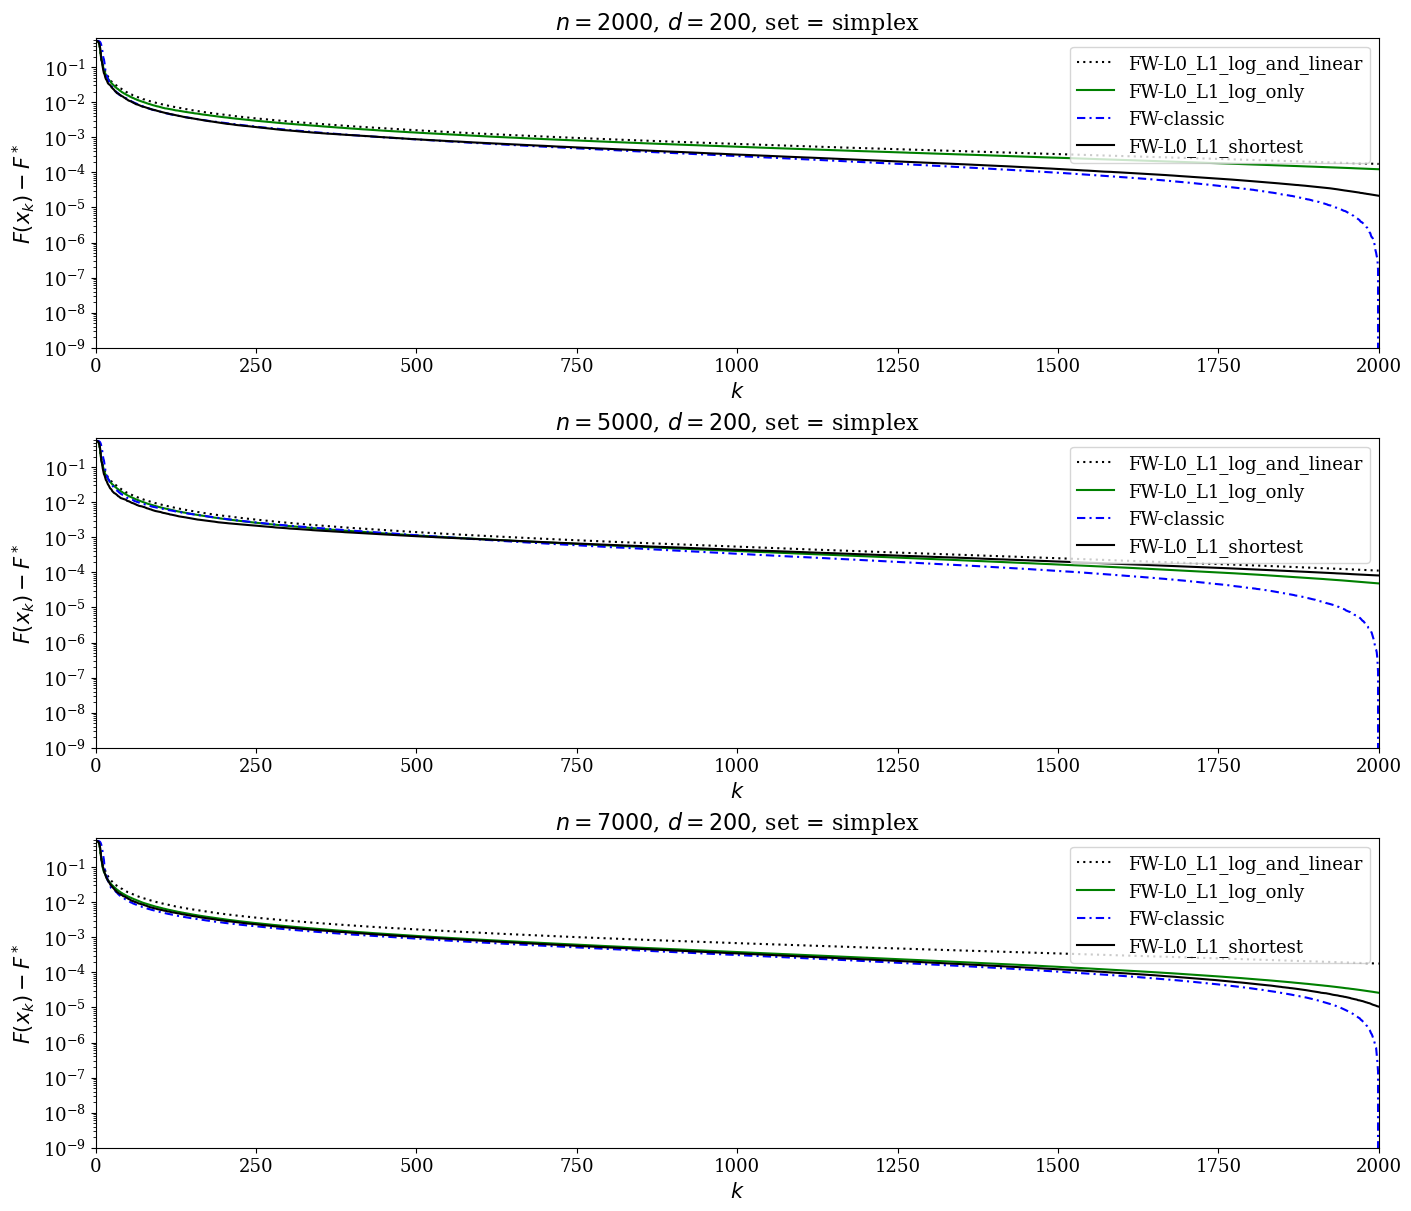

In [17]:
fig, axes = plt.subplots(
    3, 1,
    figsize=(14, 12),
    sharex=False,
    sharey=False,
    constrained_layout=True
)


eps = 1e-8
max_iters = 2000
verbskip = max_iters / 10
ls_ratio = 2.2

key = jax.random.key(520)

l1_max_factor = 5
ball_constrnt_radius = 1

labels = [r"FW-L0_L1_log_and_linear", r"FW-L0_L1_log_only", r"FW-classic", r"FW-L0_L1_shortest"]

configs = [
    (2000, 200),
    (5000, 200),
    (7000, 200),
]

for i, (n_samples, n_features) in enumerate(configs):
    print(f"Running for n_samples={n_samples}, n_features={n_features}")
    f, h, L, L0, L1, x0, X_data, y_true = accbpg.hard_FW_log_reg_jax(key, 
                                                     n_samples, n_features, 
                                                     radius=ball_constrnt_radius, 
                                                     domain="simplex",
                                                     k_sparse=25,
                                                     rho=0.99,
                                                     col_scale=10.0,
                                                     flip_y=0.0,
                                                     noise=0.01)
    lmo = accbpg.lmo_simplex(ball_constrnt_radius)
    lmo_name = "simplex"

    _, F_l0l1_log, _, _, _ = accbpg.FW_l0l1_log_and_linear_step(
            f, h, L0, L1, x0, max_iters, lmo, ls_ratio=ls_ratio, 
            L1_max=L1*ls_ratio, L0_max=L0*ls_ratio, epsilon=eps, 
            linesearch=True, verbskip=verbskip
        )
    
    _, F_l0_l1_step_fixed_l1, _, _, _ = accbpg.FW_l0l1_log_only(
        f, h, L0, L1, x0, maxitrs=max_iters, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, L1_max=L1*ls_ratio, L0_max=L0*ls_ratio, linesearch=True, 
        verbskip=verbskip
    )

    _, F_standard, _, _ = accbpg.FW_alg_div_step(
        f, h, L, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    _, F_l0_l1_step, _, _ = accbpg.FW_alg_L0_L1_shortest_step(
        f, h, L0, L1, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    ax = axes[i]
    y_min = min(np.min(F_l0l1_log), np.min(F_standard), np.min(F_l0_l1_step), np.min(F_l0_l1_step_fixed_l1))
    y_max = max(np.max(F_l0l1_log), np.max(F_standard), np.max(F_l0_l1_step), np.max(F_l0_l1_step_fixed_l1))

    max_executed_iters = max(len(F_l0l1_log), len(F_standard), len(F_l0_l1_step), len(F_l0_l1_step_fixed_l1))

    accbpg.plot_comparisons(
        ax,
        [F_l0l1_log, F_l0_l1_step_fixed_l1, F_standard, F_l0_l1_step],
        labels,
        xlim=[0, max_executed_iters],
        ylim=[1e-9, y_max], plotdiff=True, yscale="log",
        xlabel=r"$k$",
        ylabel=r"$F(x_k) - F^*$",
        legendloc="upper right"
    )

    ax.set_title(f"$n = {n_samples}$, $d = {n_features}$, set = {lmo_name}")

# Optional: save the figure
# plt.savefig("FW_comparison_grid.pdf", bbox_inches='tight')
plt.show()

### Низкообусловленная задача. Симплекс. Меняем размерность.

Running for n_samples=200, n_features=2000

FW L0,L1 smooth logarithmic algorithm
     k      F(x)         L         L0         L1     log step count       time
     0    6.931e-01    6.533e+03    4.545e-13    1.751e+02        1         0.1
   200    1.854e-01    5.042e+00    4.009e-15    1.545e+00      167         1.0
   400    1.800e-01    4.771e+00    4.009e-15    1.545e+00      333         1.9
   600    1.782e-01    2.134e+00    1.822e-15    7.021e-01      502         2.8
   800    1.771e-01    4.642e+00    4.009e-15    1.545e+00      670         3.8
  1000    1.765e-01    1.015e+01    8.820e-15    3.398e+00      841         4.6
  1200    1.760e-01    1.011e+01    8.820e-15    3.398e+00     1015         5.5
  1400    1.757e-01    1.009e+01    8.820e-15    3.398e+00     1187         6.4
  1600    1.754e-01    4.574e+00    4.009e-15    1.545e+00     1355         7.3
  1800    1.753e-01    1.006e+01    8.820e-15    3.398e+00     1527         8.1

FW L0,L1 smooth algorithm with fixed L

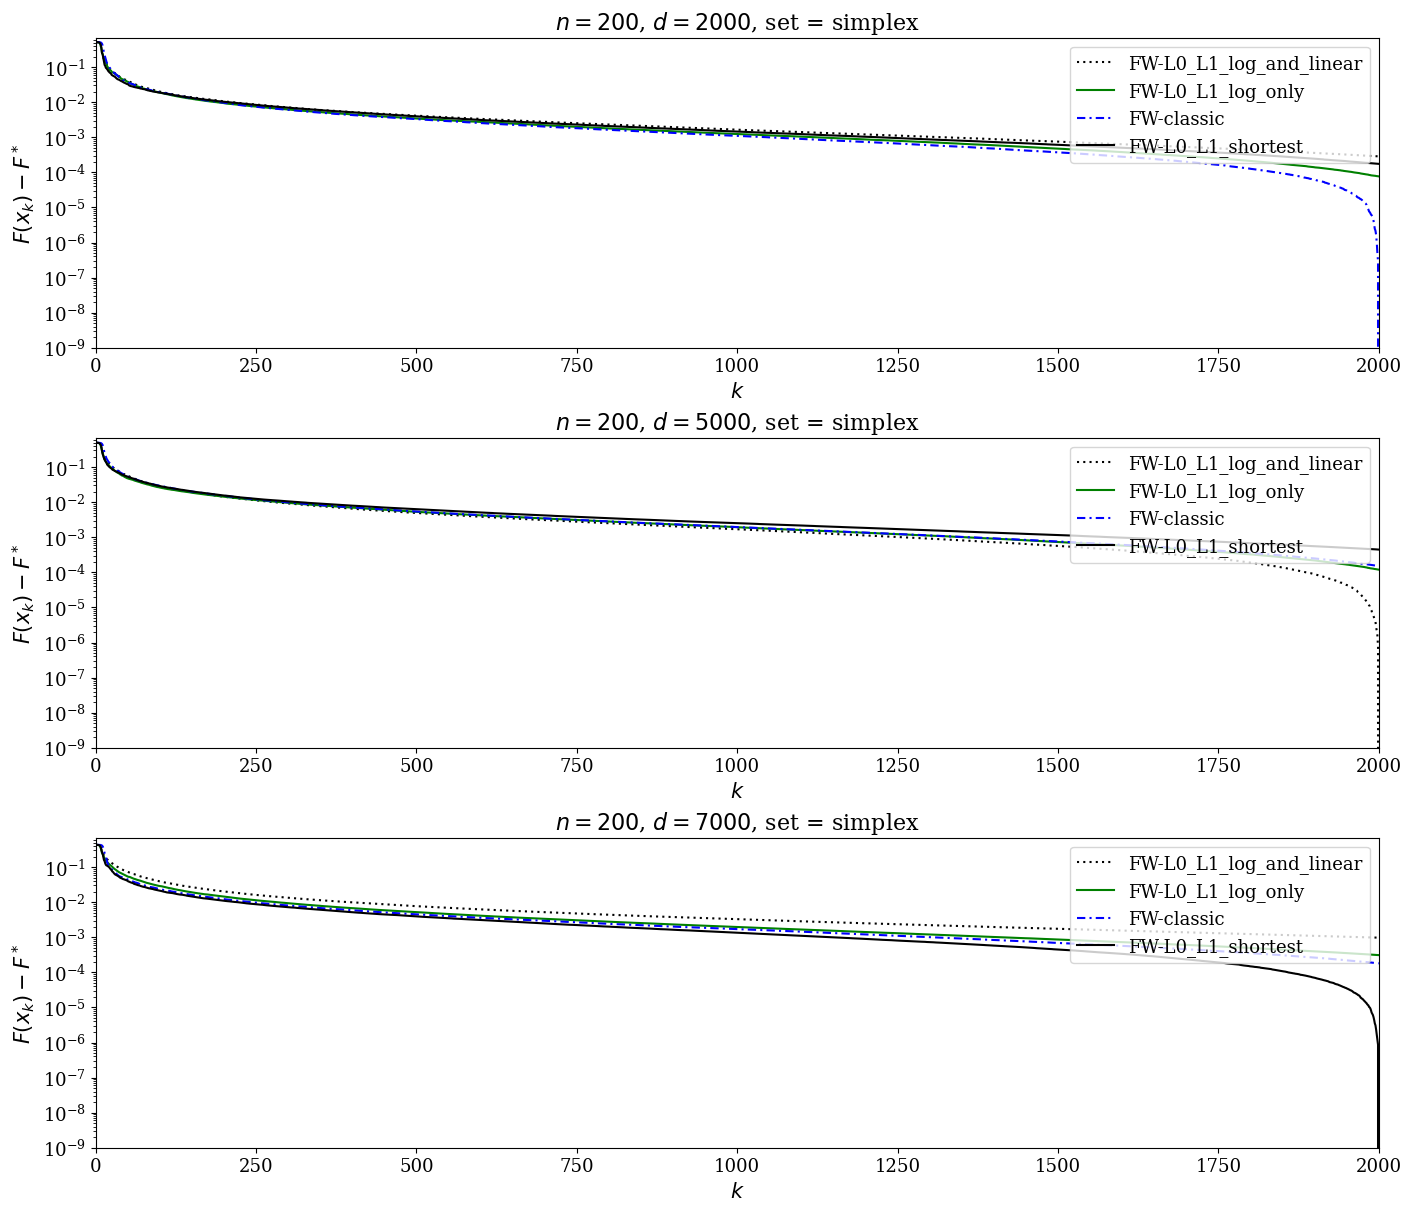

In [18]:
fig, axes = plt.subplots(
    3, 1,
    figsize=(14, 12),
    sharex=False,
    sharey=False,
    constrained_layout=True
)


eps = 1e-8
max_iters = 2000
verbskip = max_iters / 10
ls_ratio = 2.2

key = jax.random.key(520)

l1_max_factor = 5
ball_constrnt_radius = 1

labels = [r"FW-L0_L1_log_and_linear", r"FW-L0_L1_log_only", r"FW-classic", r"FW-L0_L1_shortest"]

configs = [
    (200, 2000),
    (200, 5000),
    (200, 7000),
]

for i, (n_samples, n_features) in enumerate(configs):
    print(f"Running for n_samples={n_samples}, n_features={n_features}")
    f, h, L, L0, L1, x0, X_data, y_true = accbpg.hard_FW_log_reg_jax(key, 
                                                     n_samples, n_features, 
                                                     radius=ball_constrnt_radius, 
                                                     domain="simplex",
                                                     k_sparse=25,
                                                     rho=0.99,
                                                     col_scale=10.0,
                                                     flip_y=0.0,
                                                     noise=0.01)
    lmo = accbpg.lmo_simplex(ball_constrnt_radius)
    lmo_name = "simplex"

    _, F_l0l1_log, _, _, _ = accbpg.FW_l0l1_log_and_linear_step(
            f, h, L0, L1, x0, max_iters, lmo, ls_ratio=ls_ratio, 
            L1_max=L1*ls_ratio, L0_max=L0*ls_ratio, epsilon=eps, 
            linesearch=True, verbskip=verbskip
        )
    
    _, F_l0_l1_step_fixed_l1, _, _, _ = accbpg.FW_l0l1_log_only(
        f, h, L0, L1, x0, maxitrs=max_iters, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, L1_max=L1*ls_ratio, L0_max=L0*ls_ratio, linesearch=True, 
        verbskip=verbskip
    )

    _, F_standard, _, _ = accbpg.FW_alg_div_step(
        f, h, L, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    _, F_l0_l1_step, _, _ = accbpg.FW_alg_L0_L1_shortest_step(
        f, h, L0, L1, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    ax = axes[i]
    y_min = min(np.min(F_l0l1_log), np.min(F_standard), np.min(F_l0_l1_step), np.min(F_l0_l1_step_fixed_l1))
    y_max = max(np.max(F_l0l1_log), np.max(F_standard), np.max(F_l0_l1_step), np.max(F_l0_l1_step_fixed_l1))

    max_executed_iters = max(len(F_l0l1_log), len(F_standard), len(F_l0_l1_step), len(F_l0_l1_step_fixed_l1))

    accbpg.plot_comparisons(
        ax,
        [F_l0l1_log, F_l0_l1_step_fixed_l1, F_standard, F_l0_l1_step],
        labels,
        xlim=[0, max_executed_iters],
        ylim=[1e-9, y_max], plotdiff=True, yscale="log",
        xlabel=r"$k$",
        ylabel=r"$F(x_k) - F^*$",
        legendloc="upper right"
    )

    ax.set_title(f"$n = {n_samples}$, $d = {n_features}$, set = {lmo_name}")

# Optional: save the figure
# plt.savefig("FW_comparison_grid.pdf", bbox_inches='tight')
plt.show()

## Сильно сдвинутое решение. $L_2$-шар

Running for n_samples=2000, n_features=50

FW L0,L1 smooth logarithmic algorithm
     k      F(x)         L         L0         L1     log step count       time
     0    6.931e-01    1.561e+03    4.545e-13    1.035e+02        1         0.1
   200    5.369e-01    1.971e+02    2.343e-11    5.333e+03      201         1.0
   400    5.365e-01    1.240e+02    2.343e-11    5.333e+03      401         2.0
   600    5.360e-01    7.899e+01    2.343e-11    5.333e+03      601         2.8
   800    5.356e-01    7.666e+01    2.343e-11    5.333e+03      801         3.7
  1000    5.353e-01    6.732e+01    2.343e-11    5.333e+03     1001         4.7
  1200    5.351e-01    6.446e+01    2.343e-11    5.333e+03     1201         5.6
  1400    5.349e-01    6.198e+01    2.343e-11    5.333e+03     1401         6.5
  1600    5.348e-01    5.976e+01    2.343e-11    5.333e+03     1601         7.5
  1800    5.346e-01    6.034e+01    2.343e-11    5.333e+03     1801         8.5

FW adaptive algorithm
     k      F(x) 

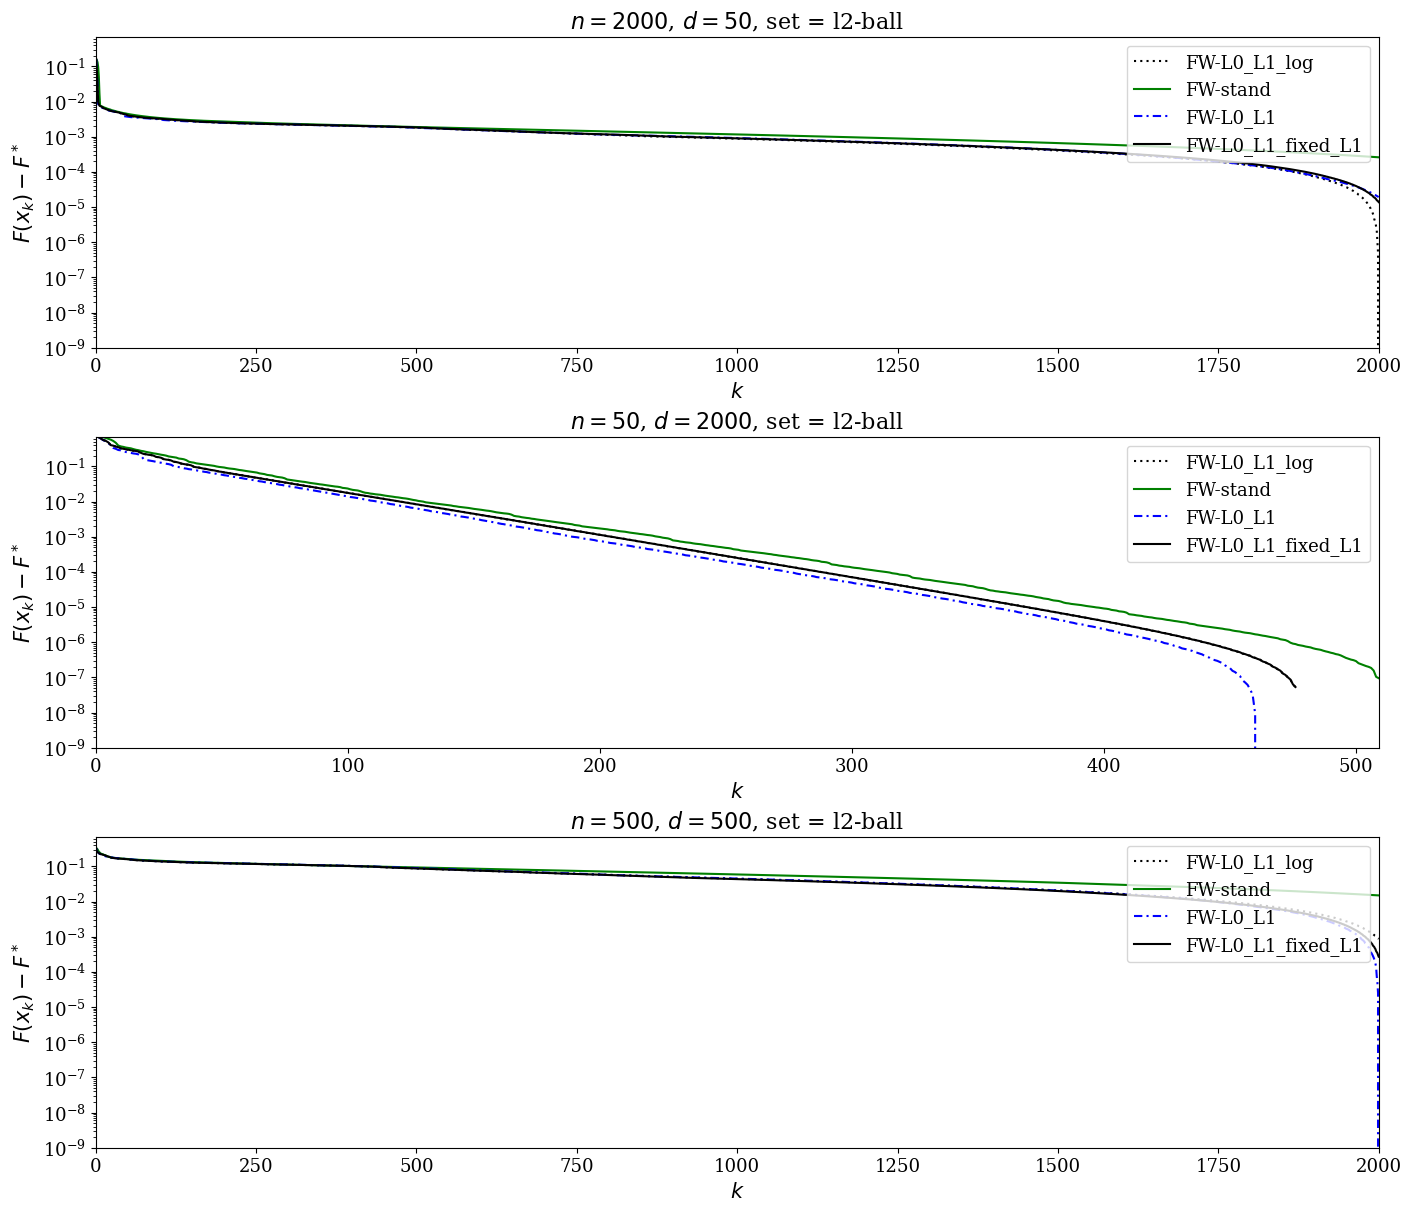

In [11]:
fig, axes = plt.subplots(
    3, 1,
    figsize=(14, 12),  # увеличенная ширина и особенно высота
    sharex=False,
    sharey=False,
    constrained_layout=True
)


eps = 1e-8
max_iters = 2000
verbskip = max_iters / 10
ls_ratio = 2.2

key = jax.random.key(41)

l1_max_factor = 5
ball_constrnt_radius = 25


labels = [r"FW-L0_L1_log", r"FW-stand", r"FW-L0_L1", r"FW-L0_L1_fixed_L1"]

configs = [
    (2000, 50),
    (50, 2000),
    (500, 500),
]

for i, (n_samples, n_features) in enumerate(configs):
    print(f"Running for n_samples={n_samples}, n_features={n_features}")
    f, h, L, L0, L1, x0, X_data, y_true = accbpg.hard_FW_log_reg_jax(key, 
                                                     n_samples, n_features, 
                                                     radius=ball_constrnt_radius, 
                                                     domain="l2",
                                                     rho=0.99,
                                                     col_scale=20.0,
                                                     flip_y=0.2,
                                                     margin=350.5,
                                                     class_bias=1.0,
                                                     noise=0.1)
    lmo = accbpg.lmo_l2_ball(ball_constrnt_radius)
    lmo_name = "l2-ball"

    _, F_l0l1_log, _, _, _ = accbpg.FW_alg_l0_l1_log_step(
            f, h, L0, L1, x0, max_iters, lmo, ls_ratio=ls_ratio, 
            L1_max=None, epsilon=eps, linesearch=True, verbskip=verbskip
        )

    _, F_standard, _, _ = accbpg.FW_alg_div_step(
        f, h, L, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    _, F_l0_l1_step, _, _ = accbpg.FW_alg_L0_L1_step(
        f, h, L0, L1, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    _, F_l0_l1_step_fixed_l1, _, _, _ = accbpg.FW_alg_l0_l1_fixed_l1(
        f, h, L0, L1, x0, maxitrs=max_iters, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    y_min = min(np.min(F_l0l1_log), np.min(F_standard), np.min(F_l0_l1_step), np.min(F_l0_l1_step_fixed_l1))
    y_max = max(np.max(F_l0l1_log), np.max(F_standard), np.max(F_l0_l1_step),  np.max(F_l0_l1_step_fixed_l1))

    max_executed_iters = max(len(F_l0l1_log), len(F_standard), len(F_l0_l1_step), len(F_l0_l1_step_fixed_l1))

    ax = axes[i]
    accbpg.plot_comparisons(
        ax,
        [F_l0l1_log, F_standard, F_l0_l1_step, F_l0_l1_step_fixed_l1],
        labels,
        xlim=[0, max_executed_iters],
        ylim=[1e-9, y_max],  # Adjusted for log scale
        x_vals=[], plotdiff=True, yscale="log",
        xlabel=r"$k$",
        ylabel=r"$F(x_k) - F^*$",
        legendloc="upper right"
    )

    ax.set_title(f"$n = {n_samples}$, $d = {n_features}$, set = {lmo_name}")

# Optional: save the figure
# plt.savefig("FW_comparison_grid.pdf", bbox_inches='tight')
plt.show()

## Выводы



Тут я генерировал матрицу с высоким числом обусловленности (см. параметр `rho`), добавлял больше шума и делал колонки близко друг к другу (параметр `margin`). В отличии от `L0_L1_smoothness\ipynb\ex_L0_L1_and_FW_good_data.ipynb`, где новые алгоритмы лучше при увеличении размерности задачи, тут все алгоритмы сходятся примерно одинаково, на $l_2$-шаре немного все же удалось увидеть превосходство FW-L0_L1_shortest на больших размерностях. Пчму так происходит? Пока ответ я не нашел.

Что НЕ влияет на сходимость:
- Ограничение сверху параметров $L_1, L_0$ не дает никакого эффекта. Общая $a_k$ ни в одной из задач не разрасталась до огромных значений из этого поэтому следует, что ни $L_1$ ни $L_0$ не разрастаются сильно.